# 机器学习：预测泰坦尼克号灾难的幸存者

From Kaggle: Machine Learning from Disaster

https://www.kaggle.com/c/titanic

# 项目背景

- 泰坦尼克号的沉没是历史上最臭名昭著的海难之一。


- 1912年4月15日，在她的处女航中，被普遍认为“沉没”的RMS泰坦尼克号与冰山相撞后沉没。不幸的是，船上没有足够的救生艇供所有人使用，导致2224名乘客和机组人员中的1502人死亡。


- 尽管幸存有一些运气，但似乎有些人比其他人更有可能生存。

# 项目目标

- 在本项目中，我们将使用乘客数据（即姓名，年龄，性别，社会经济舱等）建立多个预测模型来回答：**“什么样的人更有可能生存？”** 。


- 最终选出最优的算法模型，对泰坦尼克号沉船事故中哪些人会幸存下来进行预测。


- 初步决定采用**`Accuracy(准确率)、F1score`**作为模型表现的评估指标。


- F1score = 2×Precision×Recall / (Precision+Recall)

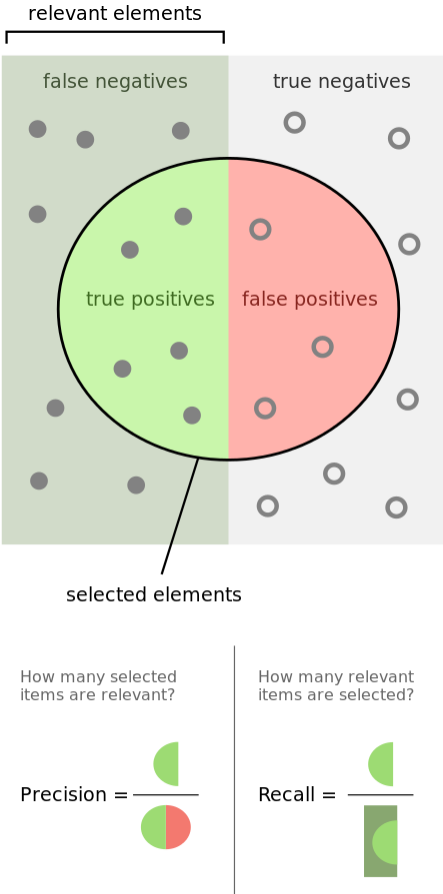

# 项目字典



- **Survived**：存活结果（0 = 存活；1 = 未存活）
- **Pclass**：社会阶层（1 = 上层；2 = 中层；3 = 底层）
- **Name**：乘客姓名
- **Sex**：乘客性别
- **Age**：乘客年龄（某些条目为 `NaN`）
- **SibSp**：一起上船的兄弟姐妹和配偶人数
- **Parch**：一起上船的父母和子女人数
- **Ticket**：乘客的票号
- **Fare**：乘客支付的票价
- **Cabin**：乘客的客舱号（某些条目为 `NaN`）
- **Embarked**：乘客的登船港（C = 瑟堡；Q = 皇后镇；S = 南安普顿）

`**Variable Notes**`

- pclass: A proxy for socio-economic status (SES)
    - 1st = Upper
    - 2nd = Middle
    - 3rd = Lower

- age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

- sibsp: The dataset defines family relations in this way...
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

- parch: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

# 数据预处理

## 数据加载

In [3]:
# 导入标准库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [4]:
df_train = pd.read_csv('titanic_data_train.csv')
df_test_features = pd.read_csv('titanic_data_test.csv')
df_test_label = pd.read_csv('gender_submission.csv')

## 数据评估

In [5]:
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
df_test_features.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [7]:
df_test_label.head(3)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


In [8]:
print('The train dataset:',df_train.shape)
print('The features of test dataset:',df_test_features.shape)
print('The label of test dataset:',df_test_label.shape)

The train dataset: (891, 12)
The features of test dataset: (418, 11)
The label of test dataset: (418, 2)


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [10]:
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [11]:
df_test_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
PassengerId    418 non-null int64
Survived       418 non-null int64
dtypes: int64(2)
memory usage: 6.6 KB


In [12]:
# 查看各列数据概况
col_list = df_train.columns
for i in col_list:
    
    print('Column name:',i)
    print('-------------------------------')
    print(df_train[i].value_counts().nlargest(20))
    print('\n')

Column name: PassengerId
-------------------------------
891    1
293    1
304    1
303    1
302    1
301    1
300    1
299    1
298    1
297    1
296    1
295    1
294    1
292    1
306    1
291    1
290    1
289    1
288    1
287    1
Name: PassengerId, dtype: int64


Column name: Survived
-------------------------------
0    549
1    342
Name: Survived, dtype: int64


Column name: Pclass
-------------------------------
3    491
1    216
2    184
Name: Pclass, dtype: int64


Column name: Name
-------------------------------
Bidois, Miss. Rosalie                 1
Lefebre, Miss. Jeannie                1
Beavan, Mr. William Thomas            1
Lemore, Mrs. (Amelia Milley)          1
Nankoff, Mr. Minko                    1
Alhomaki, Mr. Ilmari Rudolf           1
Sandstrom, Miss. Marguerite Rut       1
Zabour, Miss. Hileni                  1
Olsson, Mr. Nils Johan Goransson      1
Olsen, Mr. Ole Martin                 1
Knight, Mr. Robert J                  1
Bourke, Miss. Mary          

In [13]:
print(df_train.duplicated().sum())
print(df_test_features.duplicated().sum())
print(df_test_label.duplicated().sum())

0
0
0


- `**评估结果：**`


    - 数据集titanic_data_train.csv中含有Survived标签列，为后期训练的label，需要将其单独分离出来
    - 数据集titanic_data_test.csv中仅有对应乘客的features，将通过模型进行预测，输出01结果，形式如gender_submission.csv
    - 训练集共891行数据，测试集共418行数据，乘客拥用11个特征。
    - 数据集titanic_data_train.csv中的Age、Cabin、Embarked列分别存在177、687、2个NaN；数据集titanic_data_test.csv中的Age、Fare、Cabin分别存在86、1、327个NaN。
    - Ticket列数据存在多种形式
    - Cabin列数据存在一格写多个values的情况，可能是同行多人导致。
    - 数据集中各列value暂未发现格式不妥的情况。
    - 数据集中均不存在重复项

## 数据清理

In [14]:
# 数据备份
df = df_train.copy()
df1 = df_test_features.copy()

### 整洁度
经观察，并无整洁度问题，唯一需要进行的结构调整，是将Survived列从数据集中分离出来。

In [15]:
train_label = df['Survived']
train = df.drop(['Survived'],axis=1)

In [16]:
train.sample()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S


### 质量维度

- 处理数据集中的NaN值，尝试进行填充：首先填充0查看训练结果，之后再尝试进行合理化填充，之后核实训练结果是否改善。
- 观察和清理Ticket、Cabin列中的values格式问题。

In [17]:
train.sample(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
596,597,2,"Leitch, Miss. Jessie Wills",female,NaN,0,0,248727,33.00,NaN,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
690,691,1,"Dick, Mr. Albert Adrian",male,31.0,1,0,17474,57.00,B20,S


#### NaN值

> `**用0填充NaN**`

In [18]:
train = train.fillna(0)
train.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [19]:
test = df1.fillna(0)
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

#### Ticket列

> `**清理Ticket列格式问题**`

In [20]:
#对训练集进行Ticket清洗
train.Ticket.head(10)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
8              347742
9              237736
Name: Ticket, dtype: object

In [21]:
not_nan = train.Ticket.str.extract('([A-Z]+/?\w*[\s.]*\d*)')
not_nan.head(5)

,0
0,A/5 21171
1,PC 17599
2,STON/O2. 3101282
3,NaN
4,NaN


In [22]:
#仅返回非NaN数据行
train[not_nan.T.any()].Ticket.value_counts()

CA. 2343              7
CA 2144               6
S.O.C. 14879          5
PC 17757              4
W./C. 6608            4
LINE                  4
F.C.C. 13529          3
PC 17582              3
PC 17572              3
C.A. 31921            3
SC/Paris 2123         3
PC 17755              3
C.A. 34651            3
PC 17760              3
PC 17604              2
C.A. 33112            2
W./C. 6607            2
P/PP 3381             2
A/4 48871             2
C.A. 37671            2
PC 17558              2
PC 17611              2
A/5. 3336             2
S.O./P.P. 3           2
C.A. 2315             2
PC 17593              2
PC 17608              2
PC 17569              2
C.A. 2673             2
PC 17485              2
                     ..
A/5 21171             1
SC/Paris 2163         1
F.C.C. 13531          1
A/5 2817              1
A/5 3536              1
SOTON/O.Q. 3101311    1
C.A. 29395            1
C.A. 5547             1
PC 17483              1
STON/O 2. 3101286     1
PC 17473        

In [23]:
#仅返回为NaN数据行
train[not_nan.isnull().T.any()].Ticket.value_counts()

347082     7
1601       7
347088     6
3101295    6
382652     5
2666       4
19950      4
4133       4
113760     4
347077     4
113781     4
349909     4
17421      4
29106      3
345773     3
371110     3
35273      3
363291     3
13502      3
239853     3
230080     3
347742     3
248727     3
24160      3
110152     3
110413     3
19943      2
113505     2
13507      2
367230     2
          ..
12460      1
373450     1
220367     1
13509      1
349246     1
112058     1
28206      1
330877     1
336439     1
349249     1
28228      1
349215     1
350048     1
2648       1
349210     1
382651     1
113051     1
349239     1
239855     1
113510     1
113787     1
113792     1
348124     1
367232     1
330932     1
349223     1
234818     1
345765     1
239856     1
3460       1
Name: Ticket, Length: 514, dtype: int64

In [24]:
#将Ticket中填写为LINE值变为0
line_tozero = (lambda x : 0 if x=='LINE' else x)
train['Ticket']=train.Ticket.apply(line_tozero)

**`经以上数据剥离结果观察，Ticket编码应为纯数字，长度在3—7位数，所以需要将含有字母、符号的数据进行清理，仅留下纯数字`**

In [25]:
train['Ticket'] = train.Ticket.str.split().str[-1:].str[0].fillna(0).values.astype('int')

In [26]:
#核实数据清理情况
train.Ticket.value_counts()

1601       7
2343       7
347082     7
2144       6
3101295    6
347088     6
14879      5
382652     5
0          4
4133       4
347077     4
113781     4
19950      4
17757      4
113760     4
2666       4
17421      4
6608       4
349909     4
31921      3
248727     3
17474      3
345773     3
239853     3
2123       3
230080     3
13529      3
34651      3
110152     3
17582      3
          ..
367228     1
3101307    1
3101305    1
2680       1
2677       1
3101289    1
3101298    1
3101296    1
3101294    1
2669       1
2667       1
2690       1
27267      1
6609       1
3101293    1
312991     1
315037     1
36967      1
244270     1
244373     1
236171     1
4134       1
2693       1
350043     1
2700       1
2697       1
111240     1
2695       1
2694       1
348121     1
Name: Ticket, Length: 679, dtype: int64

In [27]:
#对测试集进行Ticket清洗
test_notnull = test.Ticket.str.extract('([A-Z]+/?\w*[\s.]*\d*)')
test_notnull

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,A/4 48871


In [28]:
test[test_notnull.T.any()].Ticket

9               A/4 48871
14            W.E.P. 5734
15          SC/PARIS 2167
18       STON/O2. 3101270
20               PC 17603
21                C 17368
22               PC 17598
23               PC 17597
24               PC 17608
25              A/5. 3337
30             SC/AH 3085
31             C.A. 31029
32              C.A. 2315
33             W./C. 6607
42     SOTON/O.Q. 3101263
45      STON/O 2. 3101291
46               PC 17594
49             C.A. 37671
51          SC/PARIS 2168
54            SC/A.3 2861
59               PC 17608
64               PC 17608
65           F.C.C. 13534
73               PC 17562
81               PC 17483
87              A/4 31416
92             F.C. 12750
97      STON/O 2. 3101268
99             A./5. 3338
105                C 4001
              ...        
319            C.A. 31029
325    SOTON/O.Q. 3101309
327              PC 17585
330            C.A. 33112
331              PC 17580
338            C.A. 31029
340            C.A. 15185
342         

In [29]:
test[test_notnull.isnull().T.any()].Ticket

0       330911
1       363272
2       240276
3       315154
4      3101298
5         7538
6       330972
7       248738
8         2657
10      349220
11         694
12       21228
13       24065
16      233734
17        2692
19        2696
26      113509
27        2698
28      113054
29        2662
34       13236
35        2682
36      342712
37      315087
38      345768
39        1601
40      349256
41      113778
43      237249
44       11753
        ...   
379     347077
380     366713
381     330910
382     364498
383     376566
385     220845
386     349911
387     244346
388     364858
389     349909
390      12749
394     315153
395      13695
396     371109
397      13567
398     347065
399      21332
400      36928
401      28664
402     112378
403     113059
404      17765
406      28666
407     113503
408     334915
410     365237
411      19928
412     347086
416     359309
417       2668
Name: Ticket, Length: 296, dtype: object

In [30]:
test['Ticket'] = test.Ticket.str.split().str[-1:].str[0]

In [31]:
test.Ticket.value_counts()

17608      5
2343       4
113503     4
220845     3
31029      3
17483      3
3101315    3
347077     3
16966      3
24065      2
17756      2
19950      2
13050      2
4001       2
113781     2
2660       2
12749      2
2144       2
13534      2
11778      2
112378     2
31352      2
13236      2
350405     2
2315       2
851        2
21228      2
36928      2
315153     2
28220      2
          ..
347090     1
29750      1
368402     1
3337       1
330920     1
349235     1
31030      1
6608       1
1222       1
1478       1
2680       1
369943     1
315083     1
250650     1
17591      1
315091     1
350026     1
9549       1
2682       1
19928      1
17592      1
350416     1
29107      1
371362     1
2696       1
26707      1
347465     1
365235     1
110469     1
113038     1
Name: Ticket, Length: 362, dtype: int64

#### Cabin列

> `**清理Cabin列格式问题**`

In [32]:
train.Cabin.value_counts().head(10)

0              687
G6               4
B96 B98          4
C23 C25 C27      4
F2               3
C22 C26          3
F33              3
E101             3
D                3
B77              2
Name: Cabin, dtype: int64

In [33]:
train.iloc[85:100].Cabin

85              0
86              0
87              0
88    C23 C25 C27
89              0
90              0
91              0
92            E31
93              0
94              0
95              0
96             A5
97        D10 D12
98              0
99              0
Name: Cabin, dtype: object

In [34]:
train.iloc[85:100].Cabin.str.extract('(\w+\s+[\w\s]*)')

,0
85,NaN
86,NaN
87,NaN
88,C23 C25 C27
89,NaN
90,NaN
91,NaN
92,NaN
93,NaN
94,NaN


In [35]:
two_three = train.Cabin.str.extract('(\w+\s+[\w\s]*)')

In [36]:
train[two_three.T.any()].Cabin

27         C23 C25 C27
75               F G73
88         C23 C25 C27
97             D10 D12
118            B58 B60
128              F E69
297            C22 C26
299            B58 B60
305            C22 C26
311    B57 B59 B63 B66
341        C23 C25 C27
390            B96 B98
435            B96 B98
438        C23 C25 C27
498            C22 C26
679        B51 B53 B55
699              F G63
700            C62 C64
715              F G73
742    B57 B59 B63 B66
763            B96 B98
789            B82 B84
802            B96 B98
872        B51 B53 B55
Name: Cabin, dtype: object

In [37]:
train[two_three.isnull().T.any()].Cabin

0         0
1       C85
2         0
3      C123
4         0
5         0
6       E46
7         0
8         0
9         0
10       G6
11     C103
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21      D56
22        0
23       A6
24        0
25        0
26        0
28        0
29        0
30        0
       ... 
860       0
861       0
862     D17
863       0
864       0
865       0
866       0
867     A24
868       0
869       0
870       0
871     D35
873       0
874       0
875       0
876       0
877       0
878       0
879     C50
880       0
881       0
882       0
883       0
884       0
885       0
886       0
887     B42
888       0
889    C148
890       0
Name: Cabin, Length: 867, dtype: object

In [38]:
train[two_three.T.any()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,C23 C25 C27,S
75,76,3,"Moen, Mr. Sigurd Hansen",male,25.00,0,0,348123,7.6500,F G73,S
88,89,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,C23 C25 C27,S
97,98,1,"Greenfield, Mr. William Bertram",male,23.00,0,1,17759,63.3583,D10 D12,C
118,119,1,"Baxter, Mr. Quigg Edmond",male,24.00,0,1,17558,247.5208,B58 B60,C
128,129,3,"Peter, Miss. Anna",female,0.00,1,1,2668,22.3583,F E69,C
297,298,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S
299,300,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.00,0,1,17558,247.5208,B58 B60,C
305,306,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
311,312,1,"Ryerson, Miss. Emily Borie",female,18.00,2,2,17608,262.3750,B57 B59 B63 B66,C



- 通过观察发现，Cabin拥有多个值的数据行，为同行的一家人，其位于同一个客舱中。
- 主观判断认为，客舱的座位号并无区别意义，而所在客舱才是将船客区分开来的关键，即如客舱号C22，座位号22并无区别意义，字母C才是区别发关键信息。
- 以下将对字母进行提取

In [39]:
#对训练集进行Cabin清洗
train['Cabin']=train.Cabin.str.split().str[-1].str[0]

In [40]:
train = train.fillna(0)

In [41]:
train.sample(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
201,202,3,"Sage, Mr. Frederick",male,0.0,8,2,2343,69.5500,0,S
628,629,3,"Bostandyeff, Mr. Guentcho",male,26.0,0,0,349224,7.8958,0,S
259,260,2,"Parrish, Mrs. (Lutie Davis)",female,50.0,0,1,230433,26.0000,0,S


In [42]:
train.Cabin.value_counts()

0    687
C     59
B     47
D     33
E     33
A     15
F      9
G      7
T      1
Name: Cabin, dtype: int64

In [43]:
#对测试集进行Cabin清洗
test['Cabin']=test.Cabin.str.split().str[-1].str[0].fillna(0)

In [44]:
test.sample(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
253,1145,3,"Salander, Mr. Karl Johan",male,24.0,0,0,7266,9.3250,0,S
261,1153,3,"Nilsson, Mr. August Ferdinand",male,21.0,0,0,350410,7.8542,0,S
278,1170,2,"Ware, Mr. John James",male,30.0,1,0,31352,21.0000,0,S


In [45]:
test.Cabin.value_counts()

0    327
C     35
B     18
D     13
E     11
A      7
F      5
G      2
Name: Cabin, dtype: int64

#### Pclass列
格式转换，将int64转为category格式

In [46]:
train['Pclass']=train['Pclass'].astype('category')

# 数据探索和可视化

In [47]:
train.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
871,872,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D,S
294,295,3,"Mineff, Mr. Ivan",male,24.0,0,0,349233,7.8958,0,S
312,313,2,"Lahtinen, Mrs. William (Anna Sylfven)",female,26.0,1,1,250651,26.0000,0,S
266,267,3,"Panula, Mr. Ernesti Arvid",male,16.0,4,1,3101295,39.6875,0,S
555,556,1,"Wright, Mr. George",male,62.0,0,0,113807,26.5500,0,S


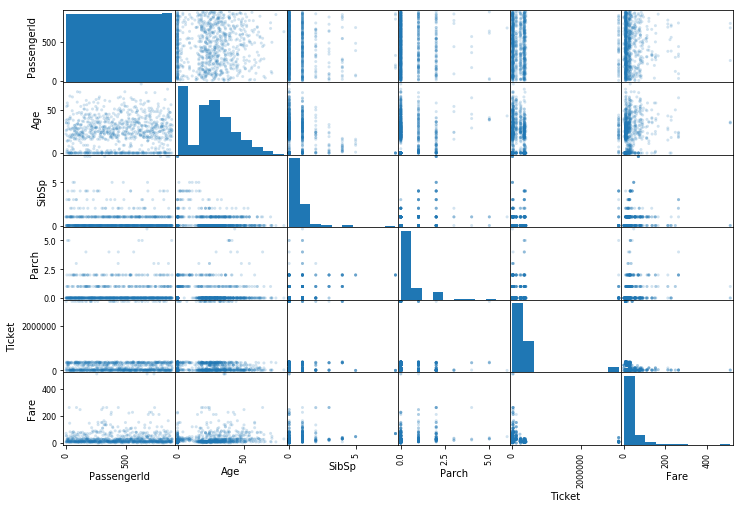

In [48]:
scatter_matrix(train,alpha=0.2,figsize=(12,8));

## 函数定义

In [49]:
# 定义函数category_plot，用于返回分类变量的柱状图，以便查看各类乘客的比例
# def category_plot(col_name):
#     train.groupby(col_name)['PassengerId'].sum().plot.bar();

## 分类变量（bar）
通过将各分类变量绘制柱状图，从而对人数比例进行观察。

In [50]:
train.sample()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
753,754,3,"Jonkoff, Mr. Lalio",male,23.0,0,0,349204,7.8958,0,S


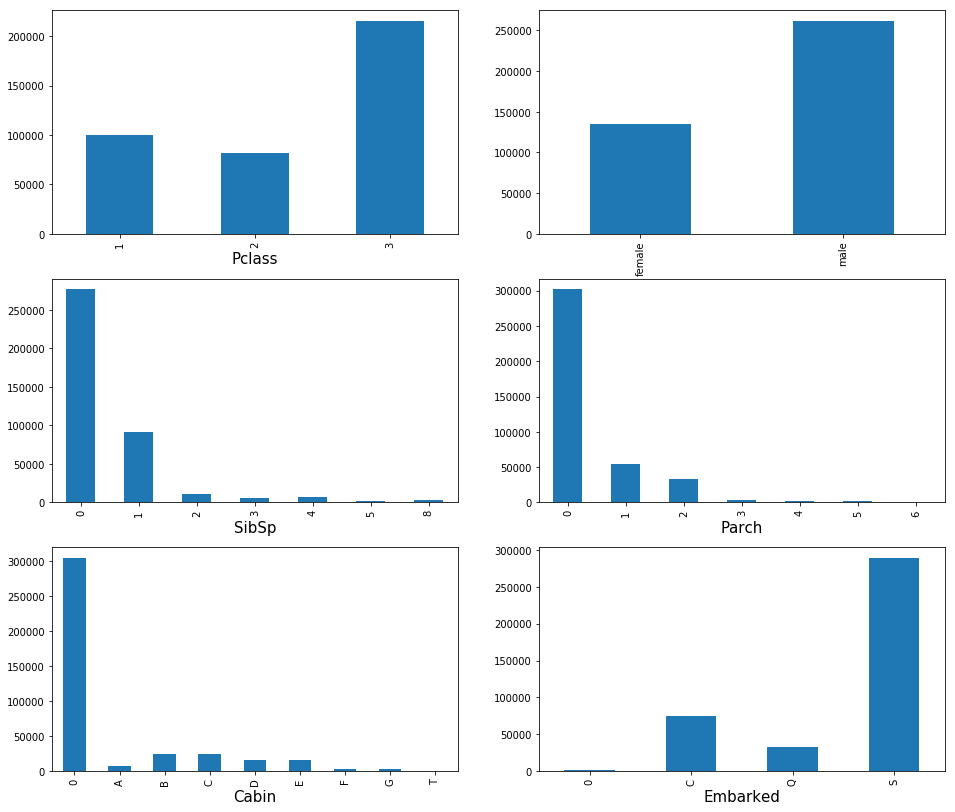

In [51]:
plt.figure(figsize=[16,14])
base_color = sns.color_palette()[0]

col_list=['Pclass', 'Sex', 'SibSp', 'Parch','Cabin', 'Embarked']
i=0
for col_name in col_list:
    if i <=5:
        plt.subplot(3,2,i+1)
        i+=1
        train.groupby(col_name)['PassengerId'].sum().plot.bar(color=base_color)
        plt.xlabel(col_name,fontsize=15);

## 数值变量（hist）

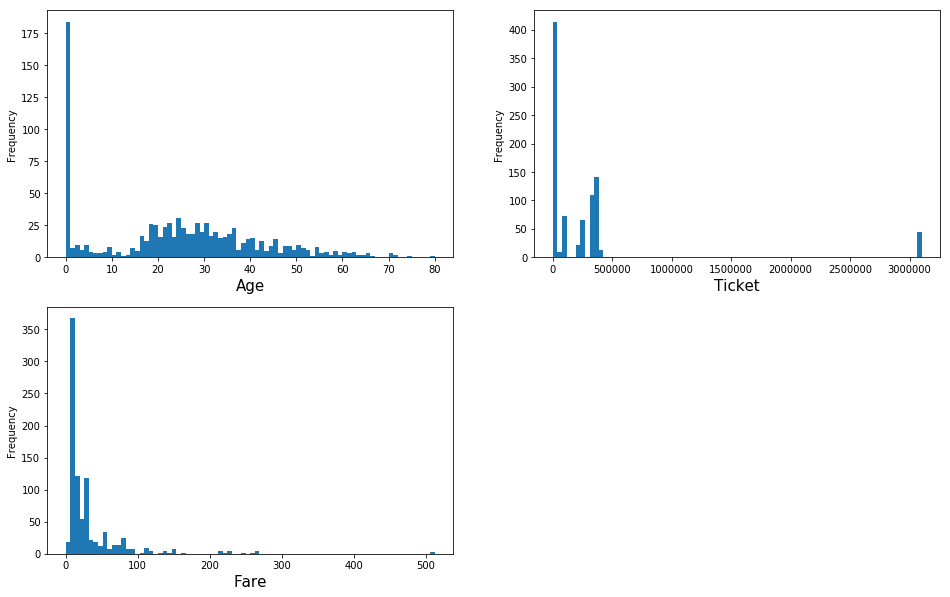

In [52]:
plt.figure(figsize=[16,10])
num_col_list=['Age','Ticket','Fare']

i=1
for col in num_col_list:
    if i <= 3:
        plt.subplot(2,2,i)
        i+=1
        train[col].plot.hist(bins=80)
        plt.xlabel(col,fontsize=15);

## 双变量

In [53]:
train.sample()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
459,460,3,"O'Connor, Mr. Maurice",male,0.0,0,0,371060,7.75,0,Q


In [54]:
def two_var_plot(x,y):
    sns.barplot(data=train,x=x,y=y,color=base_color);

/Users/cuichuanmin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


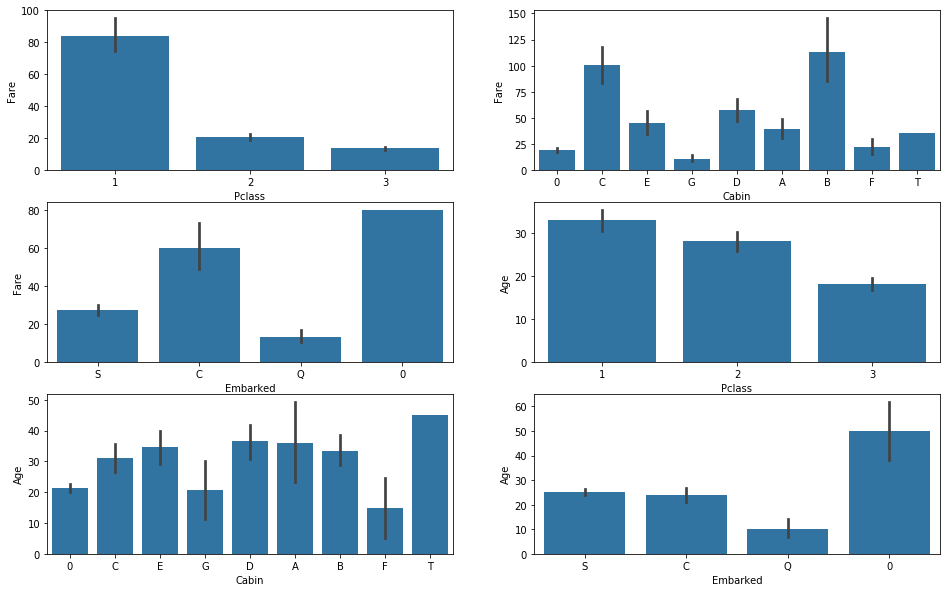

In [55]:
plt.figure(figsize=[16,10])

plt.subplot(3,2,1)
two_var_plot('Pclass','Fare')

plt.subplot(3,2,2)
two_var_plot('Cabin','Fare')

plt.subplot(3,2,3)
two_var_plot('Embarked','Fare')

plt.subplot(3,2,4)
two_var_plot('Pclass','Age')

plt.subplot(3,2,5)
two_var_plot('Cabin','Age')

plt.subplot(3,2,6)
two_var_plot('Embarked','Age');

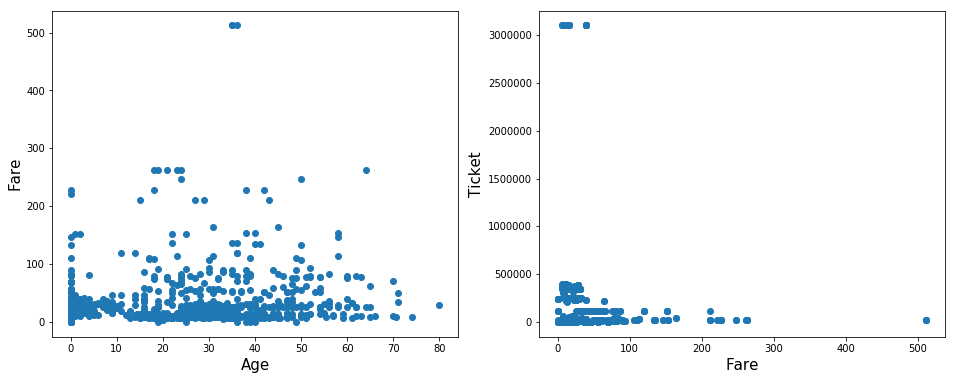

In [56]:
plt.figure(figsize=[16,6])
plt.subplot(1,2,1)
plt.scatter(data=train,x='Age',y='Fare')
plt.xlabel('Age',fontsize=15)
plt.ylabel('Fare',fontsize=15)

plt.subplot(1,2,2)
plt.scatter(data=train,x='Fare',y='Ticket')
plt.xlabel('Fare',fontsize=15)
plt.ylabel('Ticket',fontsize=15);

# 特征工程

In [57]:
# 去掉Name一列

train.drop(['Name'],axis=1,inplace=True)

## 倾斜数据的转换
针对存在极大值或者极小值的特征，算法对这种分布的数据会十分敏感，如果这种数据没能很好地归一化处理，会使得算法表现不佳。
本数据集中的**`Ticket和Fare`**特征的该现象较明显，以下进行对数转换。

In [58]:
skewed = ['Ticket','Fare']

skewed_transform = lambda x : np.log(x+1) # +1是因为0的对数没有意义

train[skewed]= train[skewed].apply(skewed_transform)

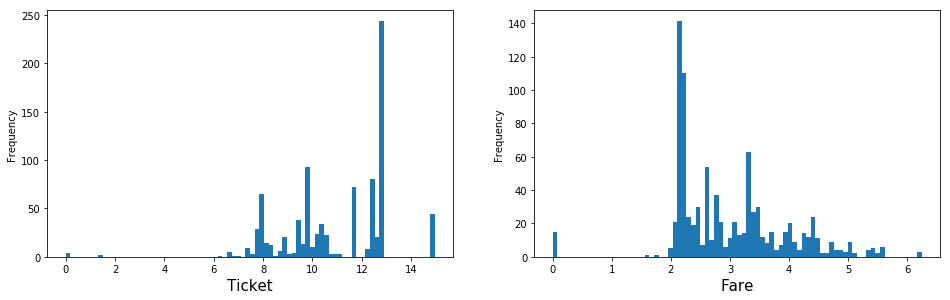

In [59]:
#核实转换情况
plt.figure(figsize=[16,10])
num_col_list=['Ticket','Fare']

i=1
for col in num_col_list:
    if i <= 3:
        plt.subplot(2,2,i)
        i+=1
        train[col].plot.hist(bins=80)
        plt.xlabel(col,fontsize=15);

## 归一化
除了对于高度倾斜的特征施加转换，对数值特征施加一些形式的缩放是一个好习惯。数据缩放并不会改变数据分布的形式，但归一化保证了每一个特征在使用监督学习器的时候能够被平等的对待。注意：一旦使用了缩放，观察数据的原始形式不再具有它本来的意义了

In [60]:
train.sample()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
250,251,3,male,0.0,0,0,12.800275,2.110213,0,S


In [61]:
# 初始化一个 scaler，并将它施加到特征上
scaler = MinMaxScaler()

num_features=['Age','SibSp','Parch','Ticket','Fare']

train[num_features]=scaler.fit_transform(train[num_features])

/Users/cuichuanmin/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [62]:
# 查看转换后的样式
train.sample()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
620,621,3,male,0.3375,0.125,0.0,0.527591,0.438698,0,C


## 独热编码
通过独热编码对分类变量进行转换，独热编码为每个非数字特征的每个类别创建一个“虚拟”变量。例如，假设someFeature有三个可能的取值A，B或者C，我们将把这个特征编码成someFeature_A, someFeature_B, someFeature_C。

In [63]:
train = pd.get_dummies(train)

train.sample()

,PassengerId,Age,SibSp,Parch,Ticket,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_0,Embarked_C,Embarked_Q,Embarked_S
465,466,0.475,0.0,0.0,1.0,0.334193,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


## 数据集拆分
拆分出训练集和验证集：x_train,y_train, x_val,y_val

# 数据建模

In [110]:
## 定义函数gridsearch_cv_fit，用于对model进行交叉验证网格搜索
def gridsearch_cv_fit(clf,params):
    
    grid_obj = GridSearchCV(clf,params,scoring=scorer,cv=7)
    grid_fit = grid_obj.fit(train,train_label)
    print('The F1-Score of clf in best parameters: %.4f'%grid_fit.best_score_)
    print('The best parameters are:',grid_fit.best_params_)
    
    return grid_fit


## 机器学习模型

In [111]:
scorer=make_scorer(f1_score)

### 决策树

In [112]:
clf_dt = DecisionTreeClassifier(random_state=7)

In [113]:
params = {'max_depth':[2,3,4,5,6,7,8,10],
          'min_samples_leaf':[5,10,15,20,25,30,35],
          'min_samples_split':[5,6,7,8,10,15]}

In [114]:
grid_fit11 = gridsearch_cv_fit(clf_dt,params)

The F1-Score of clf in best parameters: 0.7245
The best parameters are: {'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 15}


In [115]:
grid_fit11.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=15,
            min_weight_fraction_leaf=0.0, presort=False, random_state=7,
            splitter='best')